In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install einops
!pip install thop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from torch import linalg as LA

In [ ]:
import torch
import sys, os
import json
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time, random,timeit
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

import sys
sys.path.insert(0,'/content/drive/MyDrive/CapsNet/CapsNets-main/Experiment/HAM10000_9937/HAM10000_9937')

from utils import ImageShow,draw_size_acc,one_hot,setup_seed
from utils import confusion_matrix,metrics_scores,pff

setup_seed(3047)

from model import CapsNet

In [ ]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"#"Skin_Cancer"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}


try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [ ]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])
normalize = transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
# Resize = transforms.Resize((299,299))

def get_data(mode='ALL'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    # vt = int(trans)
    data_transform = {
        "train": transforms.Compose([#Resize,
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     normalize]),
        "val": transforms.Compose([#Resize,
                                   transforms.ToTensor(),
                                   normalize]),
        "test": transforms.Compose([#Resize,
                                    transforms.ToTensor(),
                                    normalize]),}
    if mode == 'ALL':
        train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform["train"])
        val_dataset = datasets.ImageFolder(root=val_dir,transform=data_transform["val"])
        test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform["test"])

        train_num = len(train_dataset)
        val_num = len(val_dataset)
        test_num = len(test_dataset)

        train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                                   pin_memory=pin_memory,
                                                   shuffle=True,num_workers=nw)
        val_loader = DataLoader(val_dataset,batch_size=V_size,
                                                   pin_memory=pin_memory,
                                                   shuffle=False,num_workers=nw)
        test_loader = DataLoader(test_dataset,batch_size=T_size,
                                                  pin_memory=pin_memory,
                                                  shuffle=False,num_workers=nw)

        print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                      val_num,
                                                                                                      test_num))
    else:
        test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform["test"])
        test_num = len(test_dataset)
        test_loader = DataLoader(test_dataset,batch_size=T_size,
                                                  pin_memory=pin_memory,
                                                  shuffle=False,num_workers=nw)
        print(f"using {test_num} images for testing.")

    data_list = test_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)

In [ ]:
data_root = os.path.abspath(os.path.join(os.getcwd(),".."))
image_path = '/content/drive/MyDrive/Skin_Cancer/FixCap Image Data/'#skin2023 HAM10000
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

BatchSize = 168
V_size = 32
T_size = 32

sub_dirs = "225h"#300
train_doc = "train"
val_doc = "val"
test_doc = "test"

train_dir=os.path.join(image_path,train_doc)
val_dir=os.path.join(image_path,val_doc)
test_dir=os.path.join(image_path,test_doc)
pin_memory = True
nw = 6#min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6])
print(f'Using {nw} dataloader workers every process.')
get_data()
print(f'Using {n_classes} classes.')

Using 6 dataloader workers every process.
using 3893 images for training, 971 images for validation, 1223 images for testing.
Using 7 classes.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
n_channels = 3 #RGB

network = CapsNet(conv_inputs=n_channels,
                     num_classes=n_classes,# category_number
                     init_weights=True,)
network = network.to(device)

In [ ]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [ ]:
# img_size = 299
# summary(network,(n_channels,300,225))

In [ ]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(21, 21), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [ ]:
# dsize = (1, 3, 300, 225)
# # mode='DS'
# input_data = torch.randn(dsize).to(device)
# pff(m_name="FixCaps",model=network,inputes=input_data)

In [ ]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    startT = timeit.default_timer()

    for batch_idx, (data, target) in enumerate(train_loader):

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

        # v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
        # v_mag = torch.norm(output,p=2,dim=(2,3), keepdim=True)
        v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#‘fro’ (default)
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)

        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size

        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 90:
            torch.save(network.state_dict(), iter_path)

    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc)
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/train_evl_result.pth')

    endT = timeit.default_timer()
    run_time = endT-startT
    print("Epoch:[{}] Running:[{:.2f}s], Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,run_time,
                                                                                                 epoch_loss,
                                                                                                 epoch_acc,best_train))

In [ ]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)

    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num

    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])
            target_one_hot = one_hot(target, length=n_classes)
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])
            v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]

            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size

            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result)
        test_acc = 100. * float(torch.div(diag_sum,all_sum))
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), test_path)
                torch.save(test_evl_result, f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")

In [ ]:
num_epochs= 120

In [ ]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    dirs = suf + f"_{sub_dirs}_nw{nw}_{num_epochs}ep_"
    print(f"suf:{suf}")
if os.path.exists(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}'):
    print (f'Store: "/content/drive/MyDrive/Fix/{img_title}/{dirs}"')
else:
    !mkdir -p /content/drive/MyDrive/Fix/{img_title}/{dirs}
iter_path = f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/train_{img_title}_{suf}.pth' #training
save_PATH = f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/best_{img_title}_{suf}.pth' #validation
last_path = f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/last_{img_title}_{suf}.pth' #training
test_path = f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/test_best_{img_title}_{suf}.pth' #testing
print(save_PATH)

suf:0711_173854
/content/drive/MyDrive/Fix/HAM10000/0711_173854_225h_nw6_120ep_/best_HAM10000_0711_173854.pth


In [ ]:
# network.load_state_dict(torch.load(last_path))
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test('val')

print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...
[12/24] Loss0.49608,ACC:0.14435
Epoch:[1] Running:[282.65s], Loss:0.58014,Acc:0.14873,Best_train:0.14873
HAM10000 ==> val ...
val_Acc:14.212%
Best_val:[14.212%]
[Train Epoch:[2]HAM10000 ==> Training] ...
[12/24] Loss0.46372,ACC:0.14782
Epoch:[2] Running:[21.43s], Loss:0.46342,Acc:0.18238,Best_train:0.18238
HAM10000 ==> val ...
val_Acc:25.232%
Best_val:[25.232%]
[Train Epoch:[3]HAM10000 ==> Training] ...
[12/24] Loss0.42599,ACC:0.23810
Epoch:[3] Running:[21.08s], Loss:0.42332,Acc:0.28359,Best_train:0.28359
HAM10000 ==> val ...
val_Acc:43.048%
Best_val:[43.048%]
[Train Epoch:[4]HAM10000 ==> Training] ...
[12/24] Loss0.39737,ACC:0.32688
Epoch:[4] Running:[23.09s], Loss:0.39048,Acc:0.34601,Best_train:0.34601
HAM10000 ==> val ...
val_Acc:50.36%
Best_val:[50.36%]
[Train Epoch:[5]HAM10000 ==> Training] ...
[12/24] Loss0.36130,ACC:0.39187
Epoch:[5] Running:[22.78s], Loss:0.36851,Acc:0.39199,Best_train:0.39199
HAM10000 ==> val ...
val_Acc:56.025%
Best_

In [ ]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [115]
[Val] ACC:96.5%.


FileNotFoundError: ignored

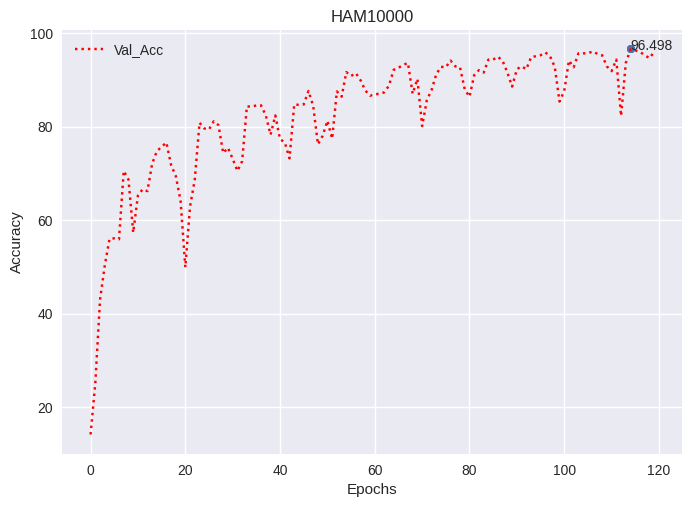

In [ ]:
show.val(write=True,custom_path='/content/drive/MyDrive/Fix',img_title=img_title,suf=dirs)

In [ ]:
show.train(opt='Acc',write=True,custom_path='/content/drive/MyDrive/Fix',img_title=img_title,suf=dirs)

FileNotFoundError: ignored

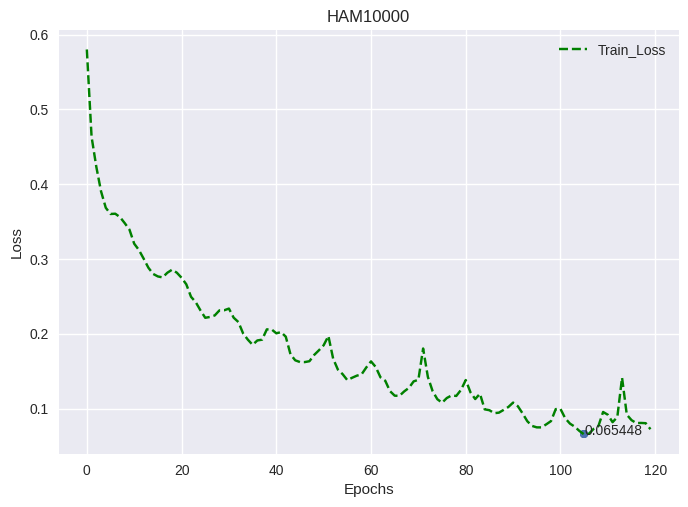

In [ ]:
plt.clf()#clear photo
show.train(write=True,custom_path='/content/drive/MyDrive/Fix',img_title=img_title,suf=dirs)

In [ ]:
network.load_state_dict(torch.load(save_PATH))

dict_bat = {}
for k in range(16,65):
    T_size = k

    print(f"T_size:{k}")
    get_data('test')

    # for j in range(3):
    test()

    if dict_bat.get(k) is None or dict_bat[k] < test_acc:
            dict_bat[k] = test_acc

T_size:16
using 1223 images for testing.
HAM10000 ==> test ...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


test_Acc:95.993%
Best_eval:[95.993%]
T_size:17
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.402%
Best_eval:[96.402%]
T_size:18
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.075%
Best_eval:[96.402%]
T_size:19
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.566%
Best_eval:[96.566%]
T_size:20
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.566%
Best_eval:[96.566%]
T_size:21
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.484%
Best_eval:[96.566%]
T_size:22
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:95.83%
Best_eval:[96.566%]
T_size:23
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.402%
Best_eval:[96.566%]
T_size:24
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.729%
Best_eval:[96.729%]
T_size:25
using 1223 images for testing.
HAM10000 ==> test ...
test_Acc:96.811%
Best_eval:[96.811%]
T_size:26
using 1223 images for testing.
HAM10000 ==> test ...
t

In [ ]:
show.conclusion(img_title=img_title)
print(sorted(dict_bat.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [14]
[Test] ACC:97.3%.
[(29, 97.3017156124115), (58, 97.13818430900574), (25, 96.81112170219421), (24, 96.72935605049133), (35, 96.64759039878845), (19, 96.5658187866211), (20, 96.5658187866211), (21, 96.48405313491821), (34, 96.48405313491821)]


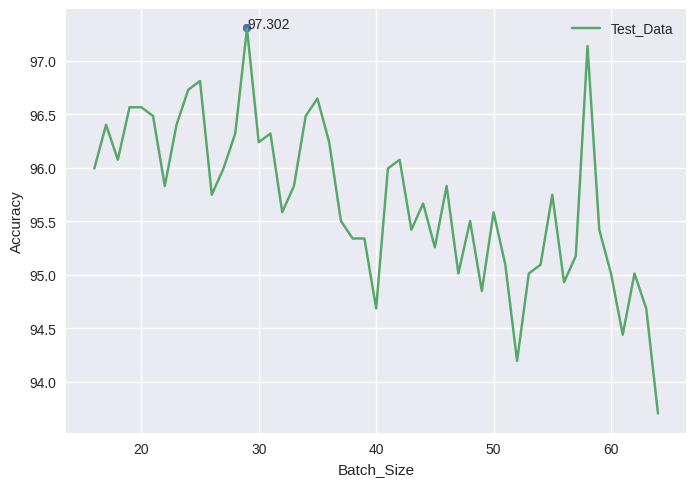

In [ ]:
draw_size_acc(dict_bat,custom_path='/content/drive/MyDrive/Fix',img_title=img_title,suf=dirs)

In [ ]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+--------+----------+
|  Type  | Precision | Recall |   F1   | Accuracy |
+--------+-----------+--------+--------+----------+
| akiec  |   0.9765  | 0.9765 | 0.9765 |          |
|  bcc   |   0.9825  | 0.9545 | 0.9683 |          |
|  bkl   |   0.9607  | 0.9771 | 0.9688 |          |
|   df   |   0.9667  | 0.9943 | 0.9803 |          |
|  mel   |   0.9563  |  1.0   | 0.9777 |          |
|   nv   |   0.9877  | 0.9091 | 0.9467 |          |
|  vasc  |   0.9832  |  1.0   | 0.9915 |          |
| Total: |   0.9733  | 0.9731 | 0.9728 |  0.973   |
+--------+-----------+--------+--------+----------+


In [ ]:
metrics_scores(val_evl_result,n_classes,cla_dict)

+--------+-----------+--------+--------+----------+
|  Type  | Precision | Recall |   F1   | Accuracy |
+--------+-----------+--------+--------+----------+
| akiec  |   0.9638  | 0.9708 | 0.9673 |          |
|  bcc   |   0.9568  | 0.9568 | 0.9568 |          |
|  bkl   |   0.9489  | 0.942  | 0.9455 |          |
|   df   |   0.9786  | 0.9928 | 0.9856 |          |
|  mel   |   0.9252  | 0.9784 | 0.951  |          |
|   nv   |   0.9846  | 0.9143 | 0.9481 |          |
|  vasc  |    1.0    |  1.0   |  1.0   |          |
| Total: |   0.9654  | 0.965  | 0.9649 |  0.965   |
+--------+-----------+--------+--------+----------+


FileNotFoundError: ignored

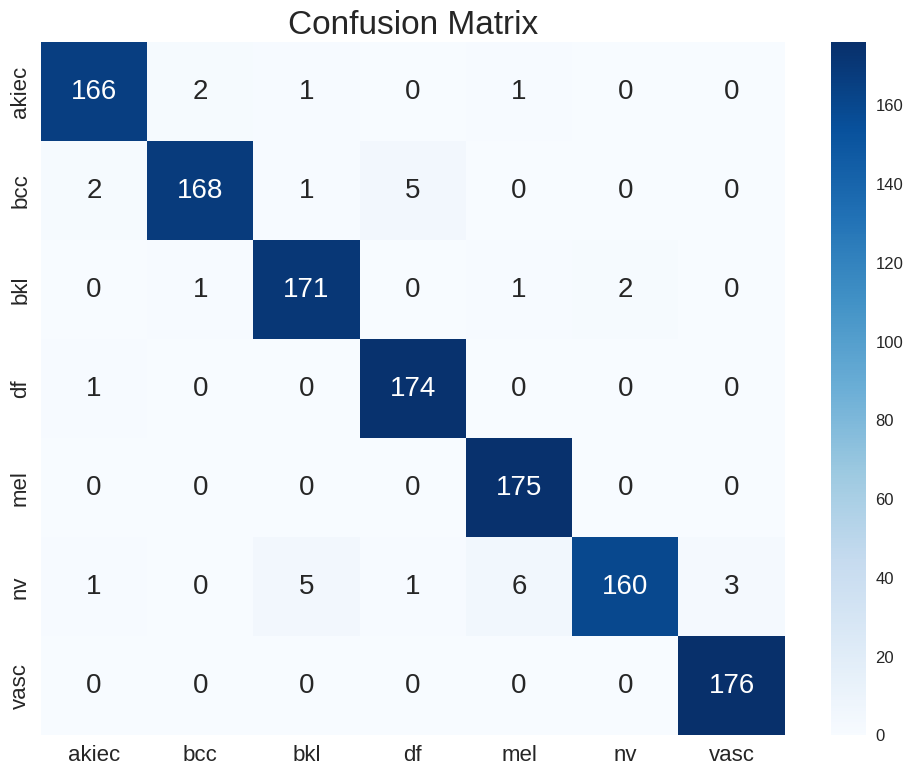

In [ ]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=dirs)

In [ ]:
# #save
s0 = np.array(train_acc_list)
np.save(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{img_title}_val_acc_{suf}.npy', s3)
s4 = np.array(dict_batch)
np.save(f'/content/drive/MyDrive/Fix/{img_title}/{dirs}/{img_title}_dict_batch_{suf}.npy', s4)

In [ ]:
torch.cuda.memory.empty_cache()

In [ ]:
# show.test(write=False,custom_path='./tmp',img_title=img_title,suf=dirs)